In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from image_extractor import DataSetup
data = DataSetup()

OS: Windows
0 :  overall_geometry
1 :  overall_rgb
2 :  overall_hsv
3 :  color_grid
4 :  glcm_grid
5 :  comp_hsv
6 :  lbp_hist
7 :  haralick
8 :  red_haralick
9 :  blue_haralick
10 :  green_haralick


In [2]:
data.concat(dataID=[0,1,3,4,5,6,8,9,10])
model_dir = 'D:./TF_backup/mlp/' + data.model_name + ".h5"
checkpoint_dir = 'D:./TF_checkpoint/mlp/weight/'
print(model_dir)

input_shape = (data.length,)
batch_size = 8

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

x_test size: (1260, 695)
x_train size: (7140, 695)
y_test size: (1260, 14)
y_train size: (7140, 14)
Model name = ' overall_geometry_overall_rgb_color_grid_glcm_grid_comp_hsv_lbp_hist_red_haralick_blue_haralick_green_haralick '
D:./TF_backup/mlp/overall_geometry_overall_rgb_color_grid_glcm_grid_comp_hsv_lbp_hist_red_haralick_blue_haralick_green_haralick.h5


In [3]:
normalizer = layers.Normalization()
normalizer.adapt(data.x_train)

# Define model
input_layer = layers.Input(shape=input_shape)
norm = normalizer(input_layer)
den1 = layers.Dense(1024, activation='tanh', kernel_initializer='HeNormal')(norm)
drop1 = layers.Dropout(0.2)(den1)
den2 = layers.Dense(1024, activation='tanh', kernel_initializer='HeNormal')(drop1)
drop2 = layers.Dropout(0.2)(den2)
den3 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop2)
drop3 = layers.Dropout(0.2)(den3)
den4 = layers.Dense(512, activation='tanh', kernel_initializer='HeNormal')(drop3)
drop4 = layers.Dropout(0.2)(den4)
den5 = layers.Dense(14, activation='softmax')(drop4)
model = keras.Model(input_layer, den5)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.4,
    nesterov=True,
    name='SGD',
)

model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

# model = keras.models.load_model(model_dir)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 695)]             0         
                                                                 
 normalization (Normalizatio  (None, 695)              1391      
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              712704    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

In [4]:
accu = []
history = model.fit(data.x_train, data.y_train, batch_size=16, shuffle=True, epochs=20, callbacks=[model_checkpoint])
accu.append(history)
history = model.fit(data.x_train, data.y_train, batch_size=8, shuffle=True, epochs=20, callbacks=[model_checkpoint])
accu.append(history)
history = model.fit(data.x_train, data.y_train, batch_size=4, shuffle=True, epochs=40, callbacks=[model_checkpoint])
accu.append(history)

model.save(model_dir)

Epoch 1/20
447/447 [==============================] - 4s 7ms/step - loss: 2.7882 - accuracy: 0.1234
Epoch 2/20
447/447 [==============================] - 3s 6ms/step - loss: 2.4116 - accuracy: 0.2118
Epoch 3/20
447/447 [==============================] - 3s 6ms/step - loss: 2.1791 - accuracy: 0.2881
Epoch 4/20
447/447 [==============================] - 3s 6ms/step - loss: 1.9846 - accuracy: 0.3452
Epoch 5/20
447/447 [==============================] - 3s 6ms/step - loss: 1.8433 - accuracy: 0.3755
Epoch 6/20
447/447 [==============================] - 3s 6ms/step - loss: 1.7443 - accuracy: 0.4209
Epoch 7/20
447/447 [==============================] - 3s 6ms/step - loss: 1.6565 - accuracy: 0.4396
Epoch 8/20
447/447 [==============================] - 3s 6ms/step - loss: 1.5712 - accuracy: 0.4713
Epoch 9/20
447/447 [==============================] - 2s 6ms/step - loss: 1.5192 - accuracy: 0.4891
Epoch 10/20
447/447 [==============================] - 3s 6ms/step - loss: 1.4601 - accuracy: 0.4999

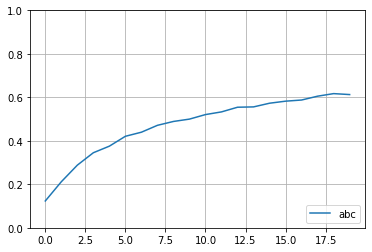

In [12]:
plt.plot(accu[0].history['accuracy'])
# plt.plot(history.history['loss'])
plt.grid(True, which='both')
plt.ylim(0,1)
plt.legend(["abc", "def"])
plt.rcParams["legend.loc"] ='lower right'


In [6]:
score = model.evaluate(data.x_test, data.y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

40/40 [==============================] - 0s 7ms/step - loss: 0.6329 - accuracy: 0.7833
Test loss: 0.632897138595581
Test accuracy: 0.7833333611488342


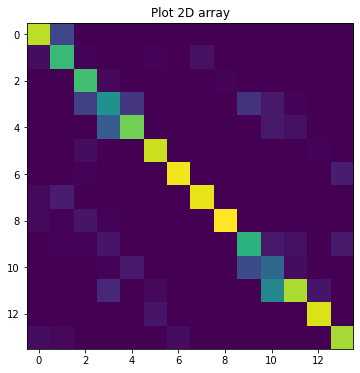

In [7]:
classes_name = ['Agglutinated', 'Brittle', 'Compartmentalized_Brown', 'Compartmentalized_PartiallyPurple', 'Compartmentalized_Purple', 'Compartmentalized_Slaty', 'Compartmentalized_White', 'Flattened', 'Moldered', 'Plated_Brown', 'Plated_PartiallyPurple', 'Plated_Purple', 'Plated_Slaty', 'Plated_White']
i = 0
cmatrix = np.zeros((14,14), dtype=np.int16)
bat = int(len(data.x_test)/60)
for i in range(0, len(data.x_test),bat):
    result = model.predict_on_batch(data.x_test[i:i+bat])
    ans = data.y_test[i:i+bat]
    for j in range(bat):
        id1 = np.argmax(result[j])
        id2 = np.argmax(ans[j])
        cmatrix[id1, id2] = cmatrix[id1][id2] + 1

cmatrix = np.absolute(cmatrix)
# print(repr(cmatrix))

fig = plt.figure(figsize=(8,8))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

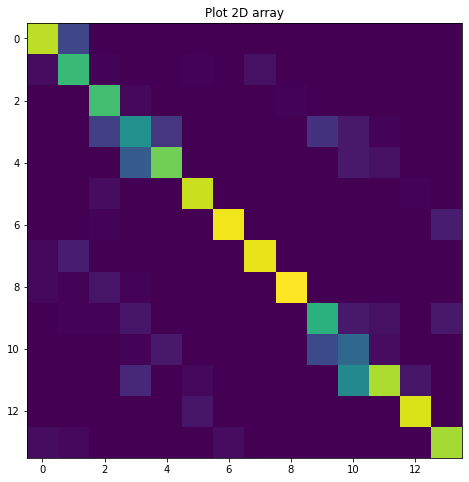

In [23]:
fig = plt.figure(figsize=(8,8))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

In [8]:
acc = []
for i in range(14):
    acc.append(np.round(cmatrix[i][i]/90,3))
    print(classes_name[i] + ': \t \t' + str(acc[i]))
print(np.mean(acc))

Agglutinated: 	 	0.889
Brittle: 	 	0.667
Compartmentalized_Brown: 	 	0.689
Compartmentalized_PartiallyPurple: 	 	0.5
Compartmentalized_Purple: 	 	0.778
Compartmentalized_Slaty: 	 	0.911
Compartmentalized_White: 	 	0.967
Flattened: 	 	0.956
Moldered: 	 	0.989
Plated_Brown: 	 	0.633
Plated_PartiallyPurple: 	 	0.333
Plated_Purple: 	 	0.867
Plated_Slaty: 	 	0.933
Plated_White: 	 	0.856
0.7834285714285713


In [24]:
ac = np.array([0], dtype=np.float32)
lo = np.array([], dtype=np.float32)
for i in range(len(accu)):
    ac = np.concatenate([ac, accu[i].history['accuracy']])
    lo = np.concatenate([lo, accu[i].history['loss']])

print(ac)
print(lo)

[0.         0.12338936 0.21176471 0.28809524 0.34523809 0.37549019
 0.42086834 0.43963584 0.4712885  0.48907563 0.49985993 0.52072829
 0.53305322 0.5544818  0.55602241 0.5729692  0.58235294 0.58767509
 0.60532212 0.61708683 0.61274511 0.62044817 0.64117646 0.65196079
 0.65462184 0.66400558 0.67296916 0.69005603 0.69271708 0.69761902
 0.69957983 0.7072829  0.70238096 0.73053223 0.72422969 0.73725492
 0.73949581 0.74397761 0.74439776 0.75308126 0.75518209 0.76498598
 0.77240896 0.77128851 0.78039217 0.78781515 0.79327732 0.7942577
 0.79397762 0.79887956 0.81652659 0.80938375 0.81610644 0.82549018
 0.82394958 0.82408965 0.83403361 0.83291316 0.84033614 0.84789914
 0.84271711 0.84537816 0.85490197 0.85490197 0.85462183 0.86050421
 0.86106443 0.86694676 0.86778712 0.86848742 0.86540616 0.87156862
 0.87450981 0.87913167 0.8865546  0.877451   0.88543415 0.88445377
 0.88963586 0.88627452 0.89005601]
[2.78818846 2.41161871 2.17912006 1.98461199 1.84330153 1.74429655
 1.65645051 1.57123828 1.519

Text(0.5, 0, 'Epoch')

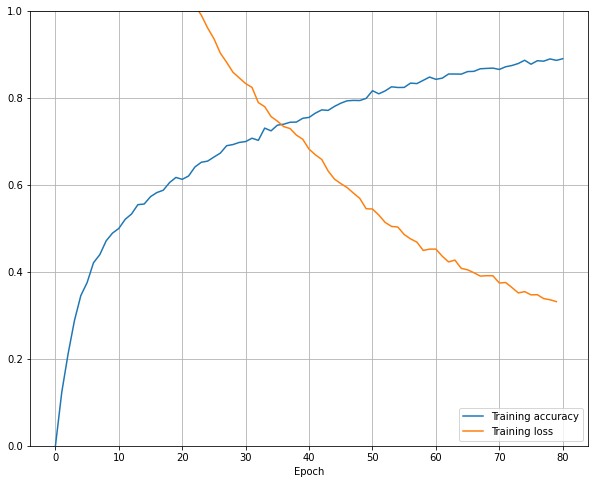

In [22]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(ac)
plt.plot(lo)
plt.grid(True, which='both')
plt.ylim(0,1)
plt.legend(["Training accuracy", "Training loss"])
plt.rcParams["legend.loc"] ='lower right'

plt.xlabel("Epoch")
